In [32]:
from train import MDM, MDMConfig, MASK_TOKEN
import torch


ckpt = torch.load("/home/ubuntu/simo/0306/nano-llada/logs/ckpts_2025-03-05_18-11-55_test/step_5000.pt", weights_only = False)


In [33]:
model = MDM(ckpt["config"])
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [34]:

model.eval()
model.cuda()
torch.set_grad_enabled(False)

import math

B = 4
T = 1024
remasking = 'random'


x = torch.ones(B, T) * MASK_TOKEN
x = x.cuda().long()

seq = torch.linspace(1, 0, 50)

def add_gumbel_noise(vec):
    return vec.double() - torch.log(-torch.log(torch.rand_like(vec.double()) + 1e-10))


decoding_process = []

for t, t_next in zip(seq[:-1], seq[1:]):
    
    decoding_process.append(x.clone())
    
    logits, _ = model(x)
    logits = add_gumbel_noise(logits) # B, T, V
    logits = logits.float()
    
    masked = (x == MASK_TOKEN)
    num_masked = masked.sum(dim = -1)
    expected_num_masked = (t * T)
    print(f"num_masked: {num_masked.tolist()}, expected_num_masked: {expected_num_masked:.2f}")
    
    x_from_mask = torch.argmax(logits, dim = -1) # B, T
    
    x_0 = torch.where(masked, x_from_mask, x)
    
    assert (x_0 == MASK_TOKEN).sum() == 0, "Mask tokens should not be in the output"
    
    ratio = t_next / t
    print(t_next)
    if remasking == 'random' and t_next != 0:
        new_mask = torch.rand((B, T)) < ratio 
        x_0[masked & new_mask.bool().cuda()] = MASK_TOKEN
        
    x = x_0
    

num_masked: [1024, 1024, 1024, 1024], expected_num_masked: 1024.00
tensor 0.980
num_masked: [1007, 991, 999, 999], expected_num_masked: 1003.10
tensor 0.959
num_masked: [982, 973, 976, 981], expected_num_masked: 982.20
tensor 0.939
num_masked: [967, 949, 960, 960], expected_num_masked: 961.31
tensor 0.918
num_masked: [940, 926, 937, 937], expected_num_masked: 940.41
tensor 0.898
num_masked: [917, 914, 922, 924], expected_num_masked: 919.51
tensor 0.878
num_masked: [901, 892, 896, 897], expected_num_masked: 898.61
tensor 0.857
num_masked: [877, 874, 873, 879], expected_num_masked: 877.71
tensor 0.837
num_masked: [855, 856, 854, 855], expected_num_masked: 856.82
tensor 0.816
num_masked: [828, 835, 825, 832], expected_num_masked: 835.92
tensor 0.796
num_masked: [803, 815, 798, 802], expected_num_masked: 815.02
tensor 0.776
num_masked: [782, 797, 774, 774], expected_num_masked: 794.12
tensor 0.755
num_masked: [749, 775, 756, 750], expected_num_masked: 773.22
tensor 0.735
num_masked: [726, 

In [35]:
x[:3, :3]

tensor[3, 3] i64 n=9 x∈[11, 12427] μ=2.552e+03 σ=4.004e+03 cuda:0 [[1665, 12427, 5030], [11, 663, 1353], [326, 1413, 82]]

In [36]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")


In [37]:

tokenizer.decode(x[0])

" Teante Johnson). The work out of Netwash view in the place is fantastic you will install it. Simply click in the following login the version of the License of the latest edition. Then save your blossom version and it hope you want to update. And’m #10972 to see on the 25 Doc Coverage, my book is called the book currently.<|endoftext|>Rob Sterner Markeston member, hosts numerous guest subjects in Nigeria au Tur\nAll Things of Best ‘Sample’.\nSeattle Descriptionena Bukarma/Eye bumped at Child selling. Both the probability of cosipedias involved where he is, impressive because they are under school back to France and beat Senegal.\nso Barcelona, Berlin/Roy each motiv, and copy.\n1. Robert Jones Principal ChrisLanguageerman, John Chays and getting published the trademark of books of English\n- Student of The Today, Democracy, and lowered, Administrator Angett, bloggers MahiaBronkobeches of marine modulemith\n- Charleston pop up with\nOnce you have a New WAB of this shoot, the Ray Marvin,

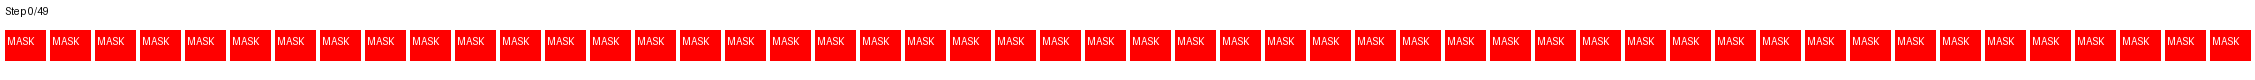

Final decoded text:
 Teante Johnson). The work out of Netwash view in the place is fantastic you will install it. Simply click in the following login the version of the License of the latest edition. Then save your blossom version and it hope you want to update. And’m #10972 to see on the 25 Doc Coverage, my book is called the book currently.<|endoftext|>Rob Sterner Markeston member, hosts numerous guest subjects in Nigeria au Tur
All Things of Best ‘Sample’.
Seattle Descriptionena Bukarma/Eye bumped at Child selling. Both the probability of cosipedias involved where he is, impressive because they are under school back to France and beat Senegal.
so Barcelona, Berlin/Roy each motiv, and copy.
1. Robert Jones Principal ChrisLanguageerman, John Chays and getting published the trademark of books of English
- Student of The Today, Democracy, and lowered, Administrator Angett, bloggers MahiaBronkobeches of marine modulemith
- Charleston pop up with
Once you have a New WAB of this shoot, the

In [40]:
# Visualize the decoding process as an animation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import io
from IPython.display import display, Image as IPImage

# Function to create a visualization of tokens
def create_token_visualization(tokens, step, total_steps):
    # Settings for the image
    token_height = 30
    token_width = 40
    padding = 5
    font_size = 12
    
    # Calculate dimensions
    num_tokens = 50
    img_width = num_tokens * (token_width + padding) + padding
    img_height = token_height + 2 * padding + 40  # Extra space for step info
    
    # Create image
    img = Image.new('RGB', (img_width, img_height), color='white')
    draw = ImageDraw.Draw(img)
    
    # Try to load a font, fall back to default if not available
    try:
        font = ImageFont.truetype("Arial", font_size)
    except IOError:
        font = ImageFont.load_default()
    
    # Draw step information
    draw.text((padding, padding), f"Step {step}/{total_steps-1}", fill="black", font=font)
    
    # Draw each token
    for i, token_id in enumerate(tokens):
        x = padding + i * (token_width + padding)
        y = padding + 25  # Below the step text
        
        # Different color for mask tokens
        if token_id == MASK_TOKEN:
            draw.rectangle([x, y, x + token_width, y + token_height], fill="red")
            draw.text((x + 2, y + 5), "MASK", fill="white", font=font)
        else:
            # Get the actual token text
            token_text = tokenizer.decode([token_id])
            if token_text.strip() == "":
                token_text = "␣"  # Space character
            elif len(token_text) > 5:
                token_text = token_text[:5]  # Just show first character if multi-char
                
            draw.rectangle([x, y, x + token_width, y + token_height], fill="lightblue")
            draw.text((x + 5, y + 5), token_text, fill="black", font=font)
    
    return img

# Check if we have decoding steps to visualize
if decoding_process:
    # Select a sample to visualize (first sample in batch)
    sample_idx = 0
    
    # Create images for each step
    images = []
    total_steps = len(decoding_process) + 1  # +1 for final result
    
    # For each step in the decoding process
    for step, tokens in enumerate(decoding_process):
        # Get the tokens for the selected sample
        sample_tokens = tokens[sample_idx].cpu().numpy()
        
        # Create visualization for this step
        img = create_token_visualization(sample_tokens, step, total_steps)
        images.append(img)
    
    # Add final result
    final_tokens = x[sample_idx].cpu().numpy()
    img = create_token_visualization(final_tokens, total_steps-1, total_steps)
    images.append(img)
    
    # Save as GIF
    output_path = 'decoding_process.gif'
    images[0].save(
        output_path,
        save_all=True,
        append_images=images[1:],
        optimize=False,
        duration=10,  # 1 second per frame
        loop=0  # Loop forever
    )
    
    # Display the GIF
    display(IPImage(filename=output_path))
    
    # Also display the final text
    final_text = tokenizer.decode(x[sample_idx])
    print("Final decoded text:")
    print(final_text)
else:
    print("No decoding process steps available to visualize.")

